# T7 - Calibration

We saw in Tutorial 4 how to load and plot data. But the next step is to actually *calibrate* the model to the data, i.e. find the model parameters that are the most likely explanation for the observed data. This tutorial gives an introduction to the Fit object and some recipes for optimization approaches.

## The Fit object

The Fit object is responsible for quantifying how well a given model run matches the data. Let's consider a simple example, building on Tutorial 4:

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


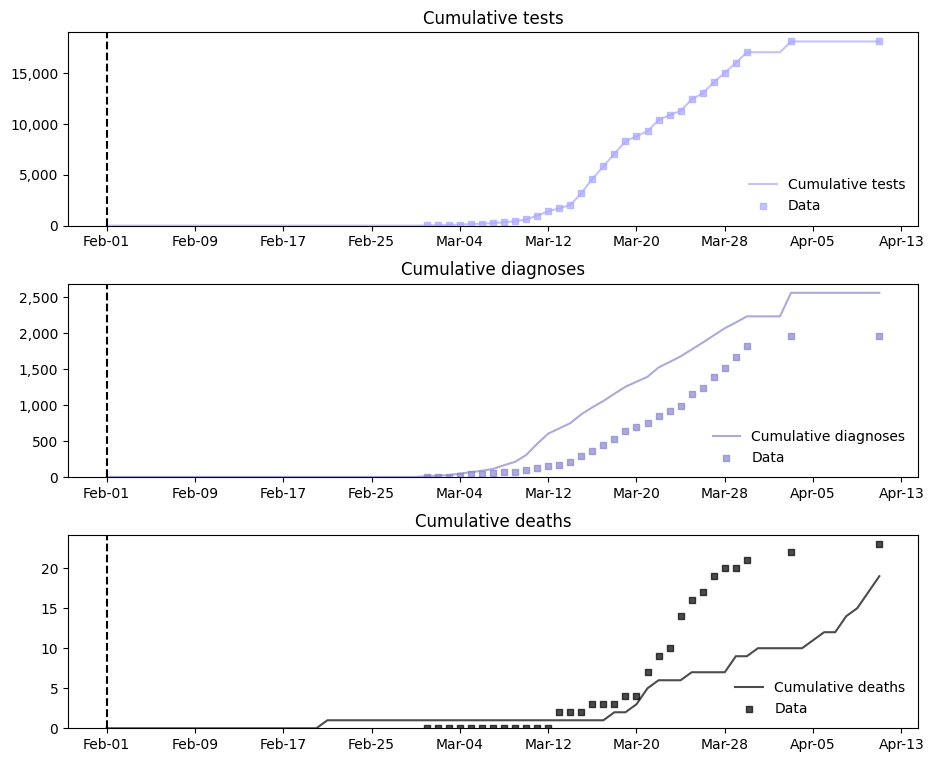

In [1]:
import covasim as cv
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

pars = dict(
    start_day = '2020-02-01',
    end_day   = '2020-04-11',
    beta      = 0.015,
)
sim = cv.Sim(pars=pars, datafile='example_data.csv', interventions=cv.test_num(daily_tests='data'))
sim.run()
sim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

We can see that tests match extremely well (they're input data!), diagnoses match reasonably well, and deaths match poorly. Can the Fit object capture our intuition about this?

In [2]:
fit = sim.compute_fit()
print(fit.mismatches)
print(fit.mismatch)

#0: cum_tests.     0.0
#1: cum_diagnoses. 34.03728294177732
#2: cum_deaths.    53.47826086956522
87.51554381134254


So the results seem to match our intuition. (Note that by default the Fit object uses normalized absolute difference, but other estimates, such as mean squared error, are also possible.)

What if we improve the fit? Does the mismatch reduce?

#0: cum_tests.     0.0
#1: cum_diagnoses. 33.20480081716037
#2: cum_deaths.    28.26086956521739
61.46567038237776


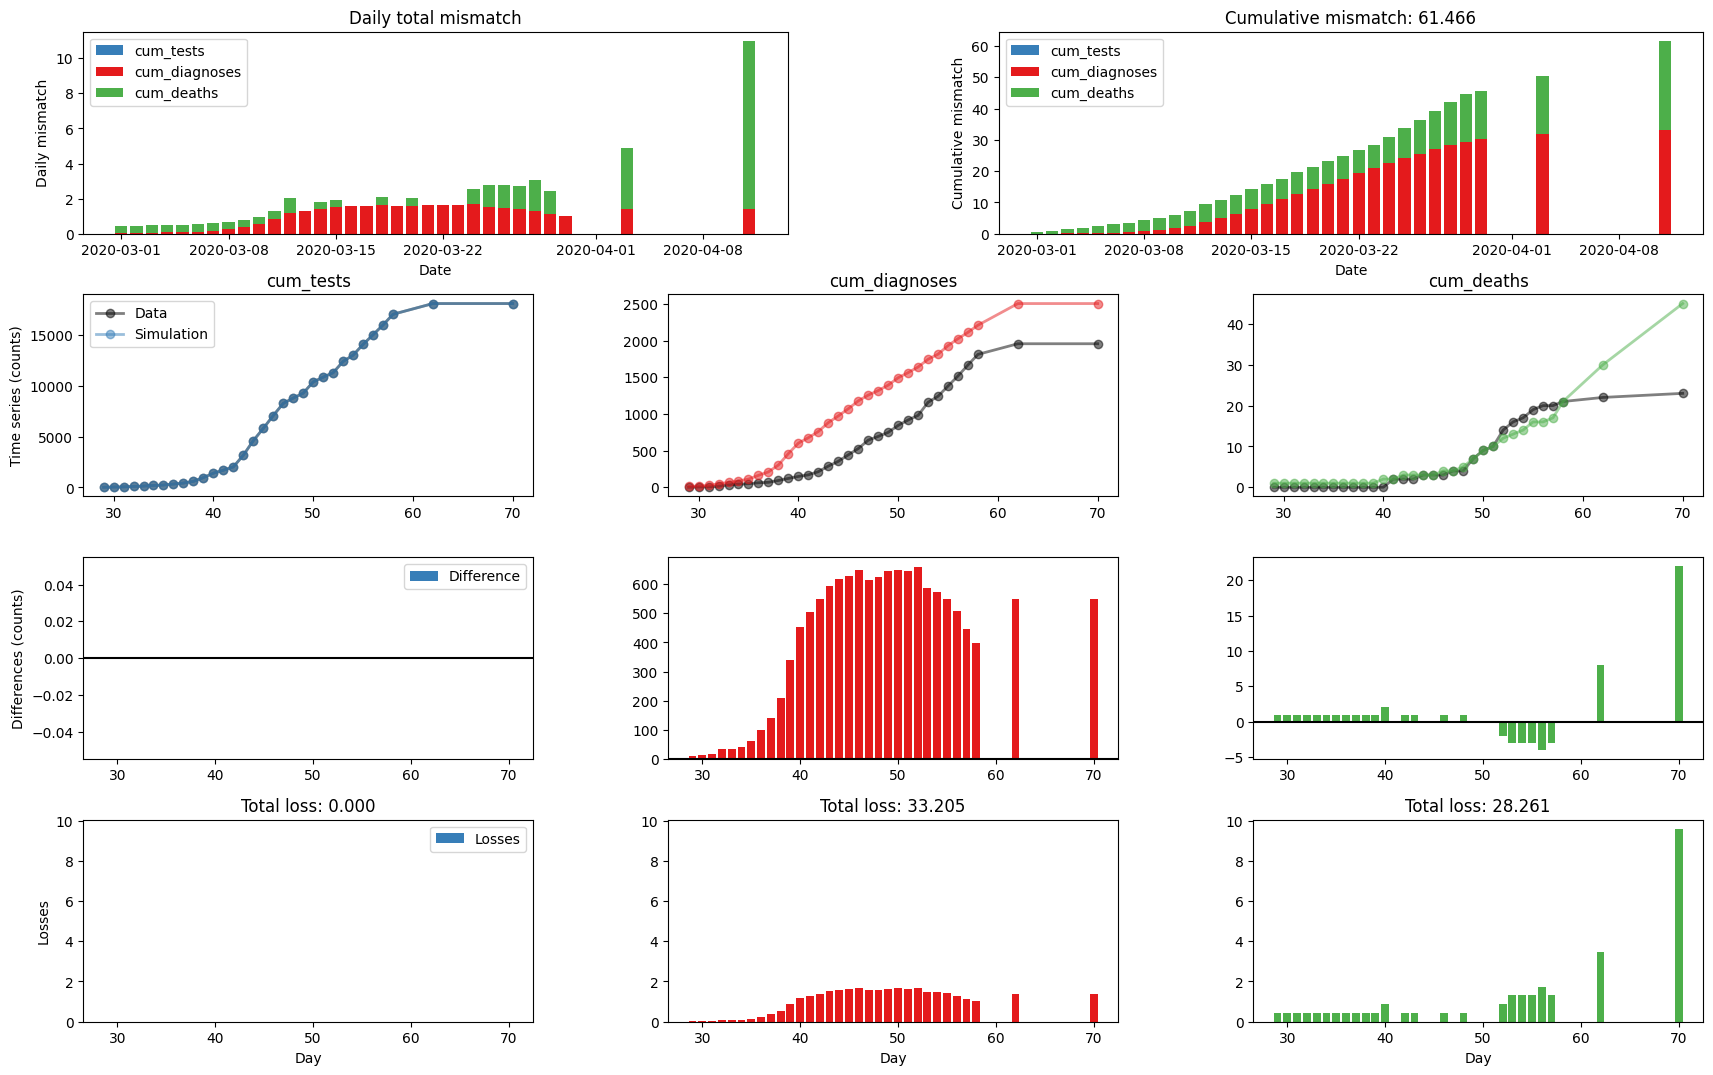

In [3]:
sim.initialize(reset=True) # Reinitialize the sim
sim['rel_death_prob'] = 2 # Double the death rate since deaths were too low

# Rerun and compute fit
sim.run()
fit = sim.compute_fit()

# Output
sim.plot()
fit.plot()
print(fit.mismatches)
print(fit.mismatch)

As expected, the fit is improved.

## Calibration approaches

Calibration is a complex and dark art and cannot be covered fully here; many books have been written about it and it continues to be an area of active research. A good review article about calibrating agent-based models like Covasim is available [here](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007893). Calibration is usually expressed as an optimization problem: specifically, find a vector of parameters *θ* that minimizes the mismatch between the data *D* and the model *M(θ)*.

In practice, most calibration is done simply by hand, as in the example above. Once deaths are "calibrated", the user might modify testing assumptions so that the diagnoses match. Since we are only fitting to deaths and diagnoses, the model is then "calibrated".

However, automated approaches to calibration are possible as well. The simplest is probably the built-in SciPy optimization functions, e.g. `scipy.optimize`. A wrinkle here is that normal gradient descent methods **will not work** with Covasim or other agent-based models, due to the stochastic variability between model runs that makes the landscape very "bumpy". One way of getting around this is to use many different runs and take the average, e.g.:

```python
import covasim as cv
import numpy as np
import scipy

def objective(x, n_runs=10):
    print(f'Running sim for beta={x[0]}, rel_death_prob={x[1]}')
    pars = dict(
        start_day      = '2020-02-01',
        end_day        = '2020-04-11',
        beta           = x[0],
        rel_death_prob = x[1],
        verbose        = 0,
    )
    sim = cv.Sim(pars=pars, datafile='/home/cliffk/idm/covasim/docs/tutorials/example_data.csv', interventions=cv.test_num(daily_tests='data'))
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    mismatches = []
    for sim in msim.sims:
        fit = sim.compute_fit()
        mismatches.append(fit.mismatch)
    mismatch = np.mean(mismatches)
    return mismatch

guess = [0.015, 1] # Initial guess of parameters -- beta and relative death probability
pars = scipy.optimize.minimize(objective, x0=guess, method='nelder-mead') # Run the optimization
```

This should converge after roughly 3-10 minutes, although you will likely find that the improvement is minimal.

What's happening here? Trying to overcome the limitations of an algorithm that expects deterministic results simply by running more sims is fairly futile – if you run *N* sims and average them together, you've only reduced noise by √*N*, i.e. you have to average together 100 sims to reduce noise by a factor of 10, and even that might not be enough. Clearly, we need a more powerful approach.

One such package we have found works reasonably well is called [Optuna](https://optuna.org/). You are strongly encouraged to read its documentation, but below is a full example to help get you started. You may wish to copy this example into a separate .py file and run it outside of the Jupyter notebook environment.

In [5]:
'''
Example for running Optuna
'''

import os
import sciris as sc
import covasim as cv
import optuna as op


def run_sim(pars, label=None, return_sim=False):
    ''' Create and run a simulation '''
    pars = dict(
        start_day      = '2020-02-01',
        end_day        = '2020-04-11',
        beta           = pars["beta"],
        rel_death_prob = pars["rel_death_prob"],
        interventions  = cv.test_num(daily_tests='data'),
        verbose        = 0,
    )
    sim = cv.Sim(pars=pars, datafile='example_data.csv', label=label)
    sim.run()
    fit = sim.compute_fit()
    if return_sim:
        return sim
    else:
        return fit.mismatch


def run_trial(trial):
    ''' Define the objective for Optuna '''
    pars = {}
    pars["beta"]           = trial.suggest_uniform('beta', 0.005, 0.020) # Sample from beta values within this range
    pars["rel_death_prob"] = trial.suggest_uniform('rel_death_prob', 0.5, 3.0) # Sample from beta values within this range
    mismatch = run_sim(pars)
    return mismatch


def worker():
    ''' Run a single worker '''
    study = op.load_study(storage=storage, study_name=name)
    output = study.optimize(run_trial, n_trials=n_trials)
    return output


def run_workers():
    ''' Run multiple workers in parallel '''
    output = sc.parallelize(worker, n_workers)
    return output


def make_study():
    ''' Make a study, deleting one if it already exists '''
    if os.path.exists(db_name):
        os.remove(db_name)
        print(f'Removed existing calibration {db_name}')
    output = op.create_study(storage=storage, study_name=name)
    return output


if __name__ == '__main__':

    # Settings
    n_workers = 2 # Define how many workers to run in parallel
    n_trials = 25 # Define the number of trials, i.e. sim runs, per worker
    name      = 'my-example-calibration'
    db_name   = f'{name}.db'
    storage   = f'sqlite:///{db_name}'

    # Run the optimization
    t0 = sc.tic()
    make_study()
    run_workers()
    study = op.load_study(storage=storage, study_name=name)
    best_pars = study.best_params
    T = sc.toc(t0, output=True)
    print(f'\n\nOutput: {best_pars}, time: {T:0.1f} s')

[I 2021-03-11 15:58:27,171] A new study created in RDB with name: my-example-calibration
[I 2021-03-11 15:58:28,896] Trial 1 finished with value: 244.05371497091087 and parameters: {'beta': 0.01824826549069546, 'rel_death_prob': 1.0818925721903123}. Best is trial 1 with value: 244.05371497091087.
[I 2021-03-11 15:58:29,722] Trial 0 finished with value: 118.69587422836078 and parameters: {'beta': 0.009708637485353805, 'rel_death_prob': 0.5627606411919845}. Best is trial 0 with value: 118.69587422836078.
[I 2021-03-11 15:58:30,013] Trial 2 finished with value: 144.61540169649598 and parameters: {'beta': 0.006123389295603373, 'rel_death_prob': 0.8592587625144819}. Best is trial 0 with value: 118.69587422836078.
[I 2021-03-11 15:58:30,970] Trial 3 finished with value: 406.1836612337345 and parameters: {'beta': 0.01805526840024343, 'rel_death_prob': 1.90766641001436}. Best is trial 0 with value: 118.69587422836078.
[I 2021-03-11 15:58:31,158] Trial 4 finished with value: 78.66722920460097 a

[I 2021-03-11 15:58:51,003] Trial 36 finished with value: 330.20195852022914 and parameters: {'beta': 0.01770409205954878, 'rel_death_prob': 2.3461325631269156}. Best is trial 26 with value: 38.751498867522315.
[I 2021-03-11 15:58:52,184] Trial 37 finished with value: 131.0633077230537 and parameters: {'beta': 0.00848204412242551, 'rel_death_prob': 2.8787966284137405}. Best is trial 26 with value: 38.751498867522315.
[I 2021-03-11 15:58:52,221] Trial 38 finished with value: 131.0633077230537 and parameters: {'beta': 0.008506940038827735, 'rel_death_prob': 2.8649522698156824}. Best is trial 26 with value: 38.751498867522315.
[I 2021-03-11 15:58:53,540] Trial 39 finished with value: 75.92918683661233 and parameters: {'beta': 0.011646761210065835, 'rel_death_prob': 2.2090852827664365}. Best is trial 26 with value: 38.751498867522315.
[I 2021-03-11 15:58:53,579] Trial 40 finished with value: 73.17060443220677 and parameters: {'beta': 0.011253664401633435, 'rel_death_prob': 2.48636239581701



Output: {'beta': 0.013370818913529654, 'rel_death_prob': 2.7605943459698556}, time: 33.2 s


Let's see how well it did:

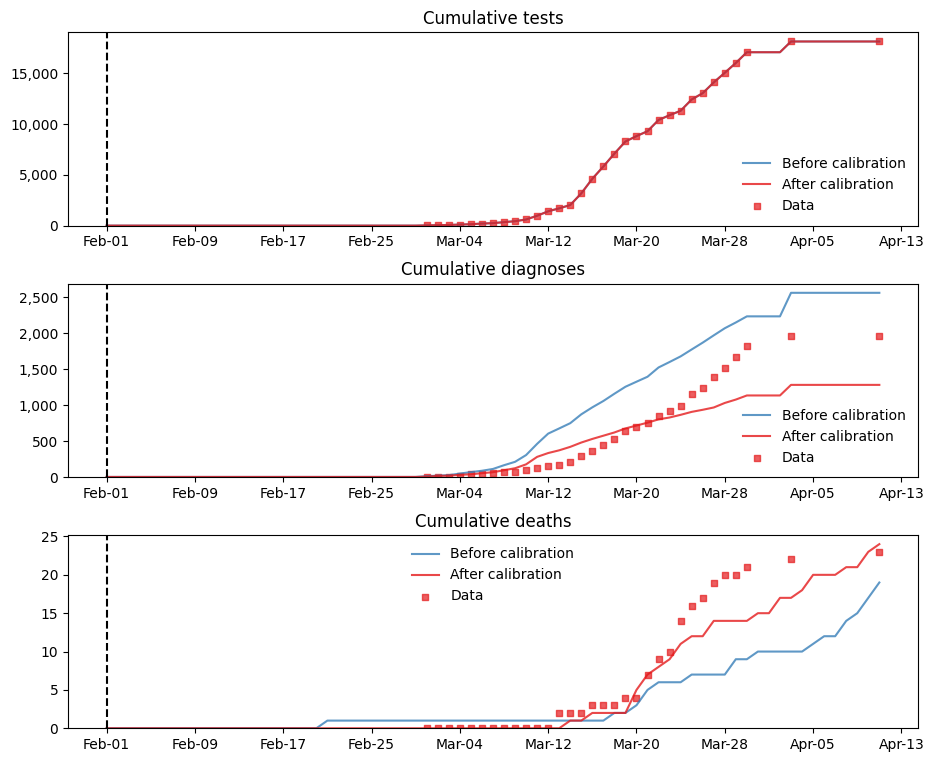

In [6]:
# Plot the results
initial_pars = dict(beta=0.015, rel_death_prob=1.0)
before = run_sim(pars=initial_pars, label='Before calibration', return_sim=True)
after  = run_sim(pars=best_pars,    label='After calibration',  return_sim=True)
msim = cv.MultiSim([before, after])
msim.plot(to_plot=['cum_tests', 'cum_diagnoses', 'cum_deaths'])

Compared to `scipy.optimize.minimize()`, Optuna took less time and produced a much better fit.